In [1]:
import nilearn
import popeye
import os
import cortex

In [2]:
picklepath='/Volumes/BAHAMUT/OUTPUT/FULL/outputs'

In [9]:
import dill
def load(filename):
	input_file = open(filename, 'rb')
	obj = dill.load(input_file)
	return obj

Get a list of the outputs that were generated from the model fitting.

In [3]:
def findgiftis(FOLDER,ext):
    
    # Function goal: return nifti files within a directory
    
    # Detail: could be used for a file with any extension...
    
    #Inputs
    
    # FOLDER (directory to search)
    # ext (the suffix (.nii or .nii.gz))
    
    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)
    import os
    import sys
    niftilist=list()
    for file in os.listdir(FOLDER):
        if file.endswith(ext) and not file.startswith('.'):
            niftilist.append(FOLDER+"/"+file)
    fprintf(sys.stdout, "Found %d gifti files \n", len(niftilist))
    return(sorted(niftilist))

mylist=findgiftis(picklepath,'.pkl')

Found 200 gifti files 


In [4]:
mylist

['/Volumes/BAHAMUT/OUTPUT/FULL/outputs/000l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/000r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/001l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/001r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/002l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/002r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/003l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/003r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/004l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/004r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/005l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/005r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/006l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/006r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/007l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/007r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/008l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/008r.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/009l.pkl',
 '/Volumes/BAHAMUT/OUTPUT/FULL/outputs/009r.pkl',


I split each hemisphere into 100 jobs (each with around 1300 vertices fit). Thus, each pickle is a list of lists -wherein each list contains a popeye model.

Split these into left and right

In [5]:
mylistL=[res for res in mylist if "l." in(res)]
mylistR=[res for res in mylist if "r." in(res)]

In [6]:
def p2panda(file):
    import pandas as pd
    fits=load(file)
    ROI=os.path.splitext(os.path.split(file)[1])[0]
    csvframe=list()
    i=0
    for fit in fits:
        df=pd.DataFrame(fit.estimate)
        df=df.T
        df.columns=['X','Y','S','h','b','u']
        df['R2'] = fit.rsquared
        df['ROI'] = ROI
        df['idx'] = fit.voxel_index[-1]
        csvframe.append(df)
        i=i+1
    frame=pd.concat(csvframe)
    return frame

In [7]:
def p2lframe(file):
    fits=load(file)
    csvframe=list()
    for fit in fits:
        longf=pd.DataFrame(fit.prediction)
        longf.columns=['pred']
        longf['data']=fit.data
        longf['X'] =np.repeat(fit.estimate[0],longf.shape[0])
        longf['Y'] =np.repeat(fit.estimate[1],longf.shape[0])
        longf['S'] =np.repeat(fit.estimate[2],longf.shape[0])
        longf['r2'] =np.repeat(fit.rsquared,longf.shape[0])
        longf['idx']= np.repeat(fit.voxel_index[-1],longf.shape[0])
        csvframe.append(longf)
    frame=pd.concat(csvframe)
    return frame




In [12]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np

lframe=list()
lframe=Parallel(n_jobs=5,verbose=9)(delayed(p2lframe)(item)  for item in mylistL)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   24.2s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.6min finished


In [13]:
rframe=list()
rframe=Parallel(n_jobs=5,verbose=9)(delayed(p2lframe)(item)  for item in mylistR)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   25.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   42.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished


In [14]:
longframe=pd.concat([pd.concat(lframe),pd.concat(rframe)])

In [15]:
dump_path='/Volumes/BAHAMUT/OUTPUT/FULL'

In [162]:
longframe.to_csv(os.path.join(dump_path,'lframe.csv'))

Load these in and append them to one another. 

In [16]:
import popeye
import dill
def load(filename):
	input_file = open(filename, 'rb')
	obj = dill.load(input_file)
	return obj

In [17]:
frameL=list()
for item in mylistL:
    frameL.append(p2panda(item))

In [18]:
frameR=list()
for item in mylistR:
    frameR.append(p2panda(item))

In [19]:
import pandas as pd
bigframeL=pd.concat(frameL)
bigframeR=pd.concat(frameR)

In [20]:
bigframe=pd.concat([bigframeL,bigframeR])

In [21]:
bigframe.head()

,X,Y,S,h,b,u,R2,ROI,idx
0,-4.030473,2.704765,10.000000,-2.516819,0.000623,0.000628,0.276955,000l,0
0,0.179200,-0.607032,2.472724,-1.976380,0.001142,0.001157,0.564186,000l,1
0,-30.473289,0.822103,0.564935,-2.989550,0.000063,-0.000470,0.040571,000l,2
0,5.843050,-50.000000,1.174882,2.994956,0.000122,-0.000432,0.019436,000l,3
0,-15.738522,23.369613,10.000000,-0.516279,0.000857,0.000155,0.449776,000l,4


Now create some empty vectors for each of the parameters we want to create.

In [22]:
import numpy as np
R2arrayL=np.zeros(163842,dtype=np.float64)
sarrayL=np.zeros(163842,dtype=np.float64)
eccarrayL=np.zeros(163842,dtype=np.float64)
angarrayL=np.zeros(163842,dtype=np.float64)
xarrayL=np.zeros(163842,dtype=np.float64)
yarrayL=np.zeros(163842,dtype=np.float64)
indL=np.zeros(163842,dtype=np.float64)

R2arrayR=np.zeros(163842,dtype=np.float64)
sarrayR=np.zeros(163842,dtype=np.float64)
eccarrayR=np.zeros(163842,dtype=np.float64)
angarrayR=np.zeros(163842,dtype=np.float64)
xarrayR=np.zeros(163842,dtype=np.float64)
yarrayR=np.zeros(163842,dtype=np.float64)
indR=np.zeros(163842,dtype=np.float64)

This formula will define polar angle in such a way that 0 is the upper vertical meridian and this increases clockwise. 

In [23]:
for i in range(bigframeL.shape[0]):
    val=bigframeL['idx'].iloc[i]
    R2arrayL[val]=bigframeL['R2'].iloc[i]*100
    sarrayL[val]=bigframeL['S'].iloc[i]
    eccarrayL[val]=np.sqrt(bigframeL['X'].iloc[i]**2+bigframeL['Y'].iloc[i]**2)
    angarrayL[val]=np.rad2deg(np.mod(np.arctan2(bigframeL['X'].iloc[i],bigframeL['Y'].iloc[i]),2*np.pi))
    xarrayL[val]=bigframeL['X'].iloc[i]
    yarrayL[val]=bigframeL['Y'].iloc[i]
    indL[val]=bigframeL['idx'].iloc[i]

In [24]:
for i in range(bigframeR.shape[0]):
    val=bigframeR['idx'].iloc[i]
    R2arrayR[val]=bigframeR['R2'].iloc[i]*100
    sarrayR[val]=bigframeR['S'].iloc[i]
    eccarrayR[val]=np.sqrt(bigframeR['X'].iloc[i]**2+bigframeR['Y'].iloc[i]**2)
    angarrayR[val]=np.rad2deg(np.mod(np.arctan2(bigframeR['X'].iloc[i],bigframeR['Y'].iloc[i]),2*np.pi))
    xarrayR[val]=bigframeR['X'].iloc[i]
    yarrayR[val]=bigframeR['Y'].iloc[i]
    indR[val]=bigframeR['idx'].iloc[i]

In [25]:
R2arrayL=np.nan_to_num(R2arrayL.reshape([1, 163842]),0)
sarrayL=np.nan_to_num(sarrayL.reshape([1, 163842]),0)
eccarrayL=np.nan_to_num(eccarrayL.reshape([1, 163842]),0)
angarrayL=np.nan_to_num(angarrayL.reshape([1, 163842]),0)

xarrayL=np.nan_to_num(xarrayL.reshape([1, 163842]),0)
yarrayL=np.nan_to_num(yarrayL.reshape([1, 163842]),0)
indL=np.nan_to_num(indL.reshape([1, 163842]),0)


In [26]:
R2arrayR=np.nan_to_num(R2arrayR.reshape([1, 163842]),0)
sarrayR=np.nan_to_num(sarrayR.reshape([1, 163842]),0)
eccarrayR=np.nan_to_num(eccarrayR.reshape([1, 163842]),0)
angarrayR=np.nan_to_num(angarrayR.reshape([1, 163842]),0)

xarrayR=np.nan_to_num(xarrayR.reshape([1, 163842]),0)
yarrayR=np.nan_to_num(yarrayR.reshape([1, 163842]),0)
indR=np.nan_to_num(indR.reshape([1, 163842]),0)


In [27]:
neurophy_path='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/prfs' 

# Export these into a curv file so that the retinotopic maps can be inferred


The instructions are as follows:

Polar angle must be in degrees of rotation clockwise starting from the upper vertical meridian. This means that the upper vertical meridian is 0°, the right horizontal meridian is 90°, the left horizontal meridian is -90°, and the lower vertical meridian is ±180°.

Eccentricity must be in degrees of visual angle from the fovea. ✅ 

Sigma/pRF size must be degrees of the visual field. ✅ 

Variance explained must be a fraction between v such that 0 ≤ v ≤ 1. ✅ (just divide by 100).


**To be clear, both the left and right hemispheres' angle files should specify the polar angle in positive degrees; for the right hemisphere, positive refers to the left visual hemi-field; for the left hemisphere, positive values refer to the right visual hemi-field. In both cases, 0 represents the upper vertical meridian and 180 represents the lower vertical meridian** 

This isn't totally clear... The thing is, I checked the example data and these seem to contain negative values (a smaller number than the positive values). This implies that the ipsilateral space is coded as negative. 

And so this seems to imply that we need to ensure that the left facing elements of the left hemisphere (greater than 180) need to be negative.

However, this seems an odd way of doing things, so I'm going to preserve my original format and store this in a new variable.

In [28]:
angarrayL2=np.copy(angarrayL)
angarrayR2=np.copy(angarrayR)

In [29]:
angarrayL2[angarrayL2>180]=angarrayL2[angarrayL2>180]-360

And for the right hemisphere, the elements to the right need to be negative.

In [30]:
angarrayR2[angarrayR2<180]=np.negative(angarrayR2[angarrayR2<180])

In [31]:
angarrayR2[angarrayR2>180]=360-angarrayR2[angarrayR2>180]

Output these to _curve files. The script that was execute on these is called /neuropythy/nprunner.sh

In [25]:
import nibabel

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_vexpl_curv'),np.squeeze(R2arrayL/100))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_vexpl_curv'),np.squeeze(R2arrayR/100))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_sigma_curv'),np.squeeze(sarrayL))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_sigma_curv'),np.squeeze(sarrayR))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_eccen_curv'),np.squeeze(eccarrayL))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_eccen_curv'),np.squeeze(eccarrayR))

nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'lh.meas_ang_curv'),np.squeeze(angarrayL2))
nibabel.freesurfer.io.write_morph_data(os.path.join(neurophy_path,'rh.meas_ang_curv'),np.squeeze(angarrayR2))

For cortex plotting, we can put all this into one long array.

In [32]:
R2array=np.concatenate([R2arrayL,R2arrayR],axis=1)
sarray=np.concatenate([sarrayL,sarrayR],axis=1)
eccarray=np.concatenate([eccarrayL,eccarrayR],axis=1)
angarray=np.concatenate([angarrayL,angarrayR],axis=1)

xarray=np.concatenate([xarrayL,xarrayR],axis=1)
yarray=np.concatenate([yarrayL,yarrayR],axis=1)
indarray=np.concatenate([indL,indR],axis=1)

In [33]:
R2array[R2array==0]=np.nan
sarray[sarray==0]=np.nan
eccarray[eccarray==0]=np.nan
angarray[angarray==0]=np.nan


xarray[xarray==0]=np.nan
yarray[yarray==0]=np.nan
#indarray[indarray==0]=np.nan


Now take the output of neuropythy and assign this as a new vector. 

In [34]:
from nilearn import surface

inferredL='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_varea.curv'
inferredR='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_varea.curv'

iL = surface.load_surf_data(inferredL)
iR = surface.load_surf_data(inferredR)
iarray=np.concatenate([iL,iR],axis=0)

inferredLa='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_angle.curv'
inferredRa='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_angle.curv'

iLa = surface.load_surf_data(inferredLa)
iRa = surface.load_surf_data(inferredRa)
iangarray=np.concatenate([iLa,iRa],axis=0)

inferredLe='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_eccen.curv'
inferredRe='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_eccen.curv'

iLe = surface.load_surf_data(inferredLe)
iRe = surface.load_surf_data(inferredRe)
ieccarray=np.concatenate([iLe,iRe],axis=0)

inferredLs='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/lh.inferred_sigma.curv'
inferredRs='/Volumes/BAHAMUT/NEUROPHY/fs_subjects/sub02/rh.inferred_sigma.curv'

iLs = surface.load_surf_data(inferredLs)
iRs = surface.load_surf_data(inferredRs)
isarray=np.concatenate([iLs,iRs],axis=0)




In [67]:
noisemod=surface.load_surf_data('/Volumes/BAHAMUT/OUTPUT/FULL/noisefit.curv')
noisemod=noisemod*100

In [35]:
import cortex as cx

The next few lines are commented out - but here I draw the appropriate boundaries according to the estimates given by neuropythy.

In [ ]:
#ROIlabs=['None','V1','V2','V3','hV4','VO1','VO2','LO1','LO2','TO1','TO2','V3b','V3a']

In [ ]:
#tempiarray=np.copy(iarray)
#def ROIMASK(region,tempiarray):
#    idx=ROIlabs.index(region)
#    tempiarray[tempiarray!=idx]=0
#    tempiarray[tempiarray==idx]=1
#    temparray=tempiarray
#    tempvert=cx.Vertex(temparray, subject='02',cmap='gist_ncar',description='Inferred atlas',threshold=1e-6)
#    cx.add_roi(tempvert,open_inkscape=True,name=region)

In [ ]:
# ROIMASK('V3a',tempiarray)

Bundle everything together for the webGL viewer

In [68]:
v1 = cx.Vertex(R2array, subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6)
v2 = cx.Vertex(sarray, subject='02',cmap='plasma',description='Sigma',threshold=1e-6)
v2i = cx.Vertex(isarray, subject='02',cmap='plasma',description='Inferred Sigma',threshold=1e-6)
v3 = cx.Vertex(eccarray, subject='02',cmap='plasma',description='Eccentrcity',vmax=15,threshold=1e-6)
v3i = cx.Vertex(ieccarray, subject='02',cmap='plasma',description='Inferred Eccentrcity',vmax=15,threshold=1e-6)
v4 = cx.Vertex(angarray, subject='02',cmap='plasma',description='Angle',threshold=1e-6)
v4i = cx.Vertex(iangarray, subject='02',cmap='plasma',description='Inferred Angle',threshold=1e-6)

v5 = cx.Vertex(xarray, subject='02',cmap='plasma',description='X position',threshold=1e-6)
v6 = cx.Vertex(yarray, subject='02',cmap='plasma',description='Y position',threshold=1e-6)
v7 = cx.Vertex(indarray, subject='02',cmap='plasma',description='index',threshold=1e-6)

v8=cx.Vertex(iarray, subject='02',cmap='gist_ncar',description='Inferred atlas',threshold=1e-6)
v9=cx.Vertex(noisemod, subject='02',cmap='plasma',description='Noise model fit',threshold=1e-6)


volumes = {
    'Variance explained': v1,
    'Sigma': v2,
    'Inferred Sigma': v2i,
    'Eccentricity': v3,
    'Inferred Eccentricity': v3i,
    'Polar angle': v4,
    'Inferred Polar angle': v4i,
    'X position': v5,
    'Y position': v6,
    'index': v7,
    'Inferred Atlas': v8,
    'Noise Model fit': v9
    
    
}

In [66]:
cx.webgl.show(data=volumes,with_curvature=True,with_sulci=True,with_rois=True,recache=True)

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 2626


<JS: window.viewer>

Now plot some flatmaps of the parameters.

In [38]:
import matplotlib.pyplot as plt

flatmap_height = 2048
full_figsize = (24, 16)

vf_extent = [-8, 8]
nr_vf_pix = 200

full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)

<Figure size 1728x1152 with 0 Axes>

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


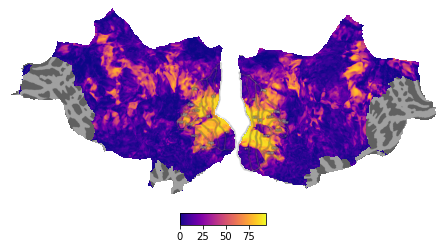

In [39]:
subject='02'

mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)
fig=cx.quickshow(v1, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)

In [40]:
fig.savefig(os.path.join(dump_path,'R2flat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


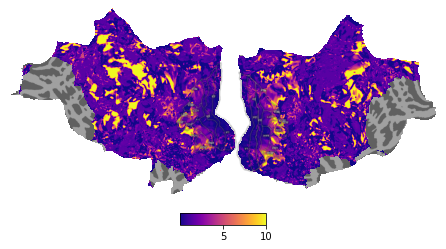

In [41]:
fig=cx.quickshow(v2, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)
fig.savefig(os.path.join(dump_path,'sigmaflat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


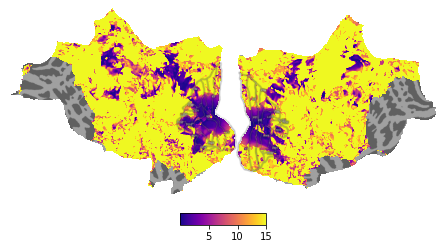

In [42]:
fig=cx.quickshow(v3, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)
fig.savefig(os.path.join(dump_path,'eccentricityflat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


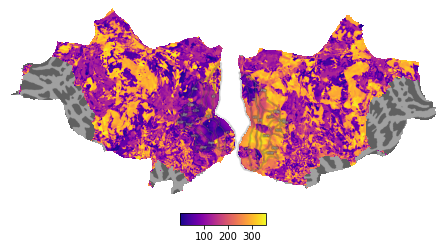

In [43]:
fig=cx.quickshow(v4, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)
fig.savefig(os.path.join(dump_path,'angleflat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None)

In [69]:
fig=cx.quickshow(v9, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)
fig.savefig(os.path.join(dump_path,'noiseflat.png'), dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,
frameon=None)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)


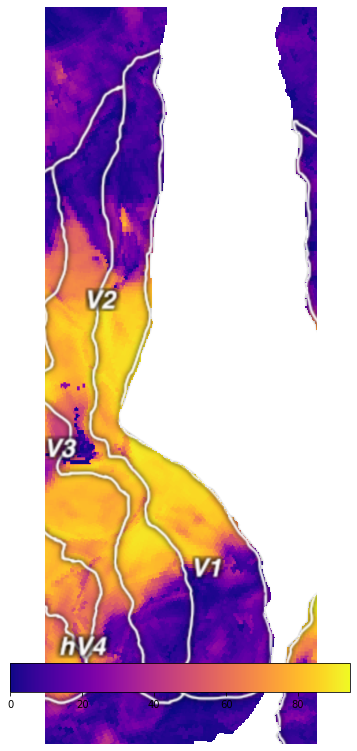

In [45]:
def zoom_to_roi(subject, roi, hem, margin=10.0):
    roi_verts = cortex.get_roi_verts(subject, roi)[roi]
    roi_map = cortex.Vertex.empty(subject)
    roi_map.data[roi_verts] = 1

    (lflatpts, lpolys), (rflatpts, rpolys) = cortex.db.get_surf(subject, "flat",
                                                                nudge=True)
    sel_pts = dict(left=lflatpts, right=rflatpts)[hem]
    roi_pts = sel_pts[np.nonzero(getattr(roi_map, hem))[0],:2]

    xmin, ymin = roi_pts.min(0) - margin
    xmax, ymax = roi_pts.max(0) + margin
    plt.axis([xmin, xmax, ymin, ymax])
    
    
# Plot it using quickflat
cortex.quickshow(v1)

# Zoom on just one region
zoom_to_roi('02','V1','left')

In [44]:
df=pd.DataFrame(np.transpose(R2array))
df.columns=['R2']
df['sigma']=np.squeeze(sarray)
df['isigma']=isarray
df['sigma']=np.squeeze(sarray)
df['ecc']=np.squeeze(eccarray)
df['iecc']=ieccarray
df['ang']=np.squeeze(angarray)
df['iang']=iangarray
df['X']=np.squeeze(xarray)
df['Y']=np.squeeze(yarray)
df['ROI']=np.squeeze(iarray)
df['idx']=np.squeeze(indarray)

In [45]:
df.to_csv(os.path.join(dump_path,'params.csv'))

In [46]:
import prfpy

/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/site-packages/prfpy/model.py:3: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [47]:
from prfpy.rf import gauss2D_iso_cart
vf_extent = [-8, 8]
nr_vf_pix = 200
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                       np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

In [48]:
import popeye
import numpy as np
import sharedmem
import popeye.og_hrf as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus
from popeye.spinach import generate_og_receptive_field

dm = np.load('/Volumes/BAHAMUT/STIM/design_matrix.npy')

# put time dimension last for popeye
dm = np.moveaxis(dm,0,2)

# binarize
dm[dm<0.5] = 0
dm[dm>0.5] = 1

# remove fixation point
dm[49,88,:] = 0
dm[49,89,:] = 0
dm[50,88,:] = 0
dm[50,89,:] = 0

#revert y axis
dm = dm[::-1,:,:] # this is how popeye wants y dim (0 point is top of dm)


TR = 1.5

stimulus = VisualStimulus(stim_arr = dm,viewing_distance = 225, screen_width =  69.84,scale_factor = 1,
                          tr_length = TR,
                          dtype = np.short)


In [75]:
np.min(stimulus.deg_x)

array(-8.77236159)

In [60]:
import matplotlib
%matplotlib qt
matplotlib.use('Qt5Agg')
fig, ax = plt.subplots(figsize=full_figsize)


cx.quickshow(v1, with_rois=True, with_curvature=True,
                     fig=ax, with_colorbar=False)

flatmap_height = 2048

subject='02'

mask, extents = cx.quickflat.utils.get_flatmask(subject, height=flatmap_height)
vc = cx.quickflat.utils._make_vertex_cache(subject, height=flatmap_height)

mask_index = np.zeros(mask.shape)
mask_index[mask] = np.arange(mask.sum())



def draw_vertex_plots(vertex,hem):
    
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()    
    
    ax2.clear()
    ax2.axhline(0, color='black', lw=0.25)
    if hem =='l':
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['pred'])[0:119])
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['data'])[0:119])
        #prf = gauss2D_iso_cart(prf_space_x,prf_space_y,[np.array(df[df['idx']==vertex]['Y'])[0],np.array(df[df['idx']==vertex]['X'])[0],np.array(df[df['idx']==vertex]['sigma'])[0]])
        
        prf = generate_og_receptive_field(np.array(df[df['idx']==vertex]['X'])[0],np.array(df[df['idx']==vertex]['Y'])[0],
        np.array(df[df['idx']==vertex]['sigma'])[0],stimulus.deg_x,stimulus.deg_y)
        
        
    else:
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['pred'])[120:238])
        ax2.plot(np.array(longframe[longframe['idx']==vertex]['data'])[120:238])
        
        
        prf = generate_og_receptive_field(np.array(df[df['idx']==vertex]['X'])[1],np.array(df[df['idx']==vertex]['Y'])[1],
        np.array(df[df['idx']==vertex]['sigma'])[1],stimulus.deg_x,stimulus.deg_y)
        
        #prf = gauss2D_iso_cart(prf_space_x,prf_space_y,
        #[np.array(df[df['idx']==vertex]['Y'])[1],
        #np.array(df[df['idx']==vertex]['X'])[1],
        #np.array(df[df['idx']==vertex]['sigma'])[1]])
        
    
    
    

    ax3.clear()
    ax3.imshow(prf, cmap='cubehelix')


    
    
    plt.draw()



def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    xmin, xmax = ax.get_xbound()
    ax_xrange = xmax-xmin
    ymin, ymax = ax.get_ybound()
    ax_yrange = ymax-ymin

    rel_x = int(mask.shape[0] * (event.xdata-xmin)/ax_xrange)
    rel_y = int(mask.shape[1] * (event.ydata-ymin)/ax_yrange)
    clicked_pixel = (rel_x, rel_y)
    
    if event.xdata<0:
        hem='l'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]
    else:
        hem='r'
        clicked_vertex = vc[int(mask_index[clicked_pixel[0], clicked_pixel[1]])]
        vindex=clicked_vertex.indices[0]-163842
    
    print(clicked_pixel)
    print(clicked_vertex)
    print(vindex)
    draw_vertex_plots(vindex,hem)
    
    
    

cid = fig.canvas.mpl_connect('button_press_event', onclick)


Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
single click: button=1, x=1788, y=915, xdata=-34.493194, ydata=-19.808084
(2275, 891)
  (0, 66384)	1.0
66384
single click: button=1, x=1788, y=987, xdata=-34.493194, ydata=-1.514317
(2275, 1013)
  (0, 87743)	1.0
87743
Stopping server
single click: button=1, x=1748, y=1007, xdata=-44.656397, ydata=3.567284
(2207, 1047)
  (0, 158595)	1.0
158595


In [54]:
BIGDATAL=load('/Volumes/BAHAMUT/DUMP/BIGLHEM.pkl')

In [55]:
BIGDATAR=load('/Volumes/BAHAMUT/DUMP/BIGRHEM.pkl')

In [56]:
psclist=[]

for i in range(120):
    psclist.append(cx.Vertex(np.squeeze(np.concatenate([BIGDATAL[i,:],BIGDATAR[i,:]])), subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6,vmin=-1,vmax=6))

In [57]:
pscdict = { i : psclist[i] for i in range(0, len(psclist))}

In [58]:
cortex.quickflat.make_gif(os.path.join(dump_path,'psc.gif'), pscdict, frame_duration=0.5)

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixe

Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixe

In [394]:
pscdict

{0: <Vertex data for 02>,
 1: <Vertex data for 02>,
 2: <Vertex data for 02>,
 3: <Vertex data for 02>,
 4: <Vertex data for 02>,
 5: <Vertex data for 02>,
 6: <Vertex data for 02>,
 7: <Vertex data for 02>,
 8: <Vertex data for 02>,
 9: <Vertex data for 02>,
 10: <Vertex data for 02>,
 11: <Vertex data for 02>,
 12: <Vertex data for 02>,
 13: <Vertex data for 02>,
 14: <Vertex data for 02>,
 15: <Vertex data for 02>,
 16: <Vertex data for 02>,
 17: <Vertex data for 02>,
 18: <Vertex data for 02>,
 19: <Vertex data for 02>,
 20: <Vertex data for 02>,
 21: <Vertex data for 02>,
 22: <Vertex data for 02>,
 23: <Vertex data for 02>,
 24: <Vertex data for 02>,
 25: <Vertex data for 02>,
 26: <Vertex data for 02>,
 27: <Vertex data for 02>,
 28: <Vertex data for 02>,
 29: <Vertex data for 02>,
 30: <Vertex data for 02>,
 31: <Vertex data for 02>,
 32: <Vertex data for 02>,
 33: <Vertex data for 02>,
 34: <Vertex data for 02>,
 35: <Vertex data for 02>,
 36: <Vertex data for 02>,
 37: <Verte

In [395]:
volumes

{'Variance explained': <Vertex movie data for 02>,
 'Sigma': <Vertex movie data for 02>,
 'Inferred Sigma': <Vertex data for 02>,
 'Eccentricity': <Vertex movie data for 02>,
 'Inferred Eccentricity': <Vertex data for 02>,
 'Polar angle': <Vertex movie data for 02>,
 'Inferred Polar angle': <Vertex data for 02>,
 'X position': <Vertex movie data for 02>,
 'Y position': <Vertex movie data for 02>,
 'index': <Vertex movie data for 02>,
 'Inferred Atlas': <Vertex data for 02>}

In [398]:
np.concatenate([BIGDATAL[1,:],BIGDATAR[1,:]]).shape

(327684,)

In [404]:
jim=cx.Vertex(np.squeeze(np.concatenate([BIGDATAL[i,:],BIGDATAR[i,:]])), subject='02',cmap='plasma',description='Variance Explained',threshold=1e-6,vmin=-1,vmax=5)

In [405]:
fig=cx.quickshow(jim, with_rois=True, with_curvature=True,fig=full_fig, with_colorbar=True)


Background RRGGBBAA: ffffff00
Area 0:0:2358.35:1024 exported to 2358 x 1024 pixels (96 dpi)
